Use GPU if available

In [1]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
    )

print(f"Using {device} device")

Using cuda device


Load CIFAR10 dataset

In [2]:
import torchvision
import torchvision.transforms as transforms

batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor()]
    )

trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
    )

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True, # reshuffle data at every epoch
    num_workers=2
    )

testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
    )

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
    )

classes = ("plane", "car", "bird", "cat", "deer",
           "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


Define the neural network

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, stride=1, padding=2)
        self.batchNorm1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, 5, stride=1, padding=2)
        self.batchNorm2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 128, 5, stride=1, padding=2)
        self.batchNorm3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(4 * 4 * 128, 2048)
        self.batchNorm4 = nn.BatchNorm1d(2048)

        self.fc2 = nn.Linear(2048, 2048)
        self.batchNorm5 = nn.BatchNorm1d(2048)

        self.out = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchNorm1(x) # batch normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.conv2(x)
        x = self.batchNorm2(x) # batch normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.conv3(x)
        x = self.batchNorm3(x) # batch normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = self.fc1(x)
        x = self.batchNorm4(x) # batch normalization
        x = F.relu(x)

        x = self.fc2(x)
        x = self.batchNorm5(x) # batch normalization
        x = F.relu(x)

        x = F.dropout(x, p=0.5)

        x = self.out(x)

        return x

Function to test the NN

In [5]:
def test_nn(net: nn.Module, verbose: bool):
    # test the neural network
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images = data[0].to(device)
            labels = data[1].to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total

    if verbose:
        print('Testing on 10,000 test images ...')
        print(f'- Correct: {correct}')
        print(f'- Total: {total}')
        print(f'- Accuracy: {accuracy}')

    return accuracy

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def train_nn(net: nn.Module, epochs: int, optimizer: torch.optim.Optimizer):
  print(f'Initialising training ...')
  print(f'- Epochs: {epochs}')
  print(f'- Batch size: {batch_size}')
  print(f'- Optimiser: {optimizer}')
  print(f'- Loss function: {F.cross_entropy}')

  running_loss_track = []
  accuracy_track = []

  # loop over the dataset multiple times
  for epoch in range(epochs):
    running_loss = 0

    # loop over the dataset in mini-batches
    for mini_batch_num, data in enumerate(trainloader, 0):
      images = data[0].to(device)
      labels = data[1].to(device)

      optimizer.zero_grad() # zero the parameter gradients

      preds = net(images) # forward mini-batch

      loss = F.cross_entropy(preds, labels) # calculate loss
      loss.backward() # calculate gradients with respect to each weight
      optimizer.step() # update weights

      running_loss += loss.item()

    accuracy = test_nn(net=net, verbose=False)
    print(f'\nEpoch {epoch} finished -- Running loss {running_loss} -- Accuracy {accuracy}')

    # track
    running_loss_track.append(running_loss)
    accuracy_track.append(accuracy)

  # plot
  fig, ax1 = plt.subplots()

  ax1.set_xlabel('Iterations over entire dataset')
  ax1.set_ylabel('Accuracy', color='b')
  ax1.plot(np.array(accuracy_track), '--b', label='Accuracy', linewidth=0.5)

  ax2 = ax1.twinx()
  ax2.set_ylabel('Running Loss', color='r')
  ax2.plot(np.array(running_loss_track), '--r', label='Loss', linewidth=0.5)

  fig.tight_layout()
  fig.legend()
  plt.show()

Create new NN model

Initialising training ...
- Epochs: 50
- Batch size: 32
- Optimiser: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.0
    nesterov: False
    weight_decay: 0
)
- Loss function: <function cross_entropy at 0x7cc6817d9750>

Epoch 0 finished -- Running loss 2042.3855981826782 -- Accuracy 61

Epoch 1 finished -- Running loss 1438.1147616505623 -- Accuracy 68

Epoch 2 finished -- Running loss 1168.1614255160093 -- Accuracy 70

Epoch 3 finished -- Running loss 951.5554018616676 -- Accuracy 70

Epoch 4 finished -- Running loss 775.9174745306373 -- Accuracy 72

Epoch 5 finished -- Running loss 622.5348513349891 -- Accuracy 74

Epoch 6 finished -- Running loss 495.77322151884437 -- Accuracy 74

Epoch 7 finished -- Running loss 393.22665701806545 -- Accuracy 74

Epoch 8 finished -- Running loss 297.56827137991786 -- Accuracy 75

Epoch 9 finished -- Running loss 239.3587222211063 -- Accuracy 74

Epoch 10 finishe

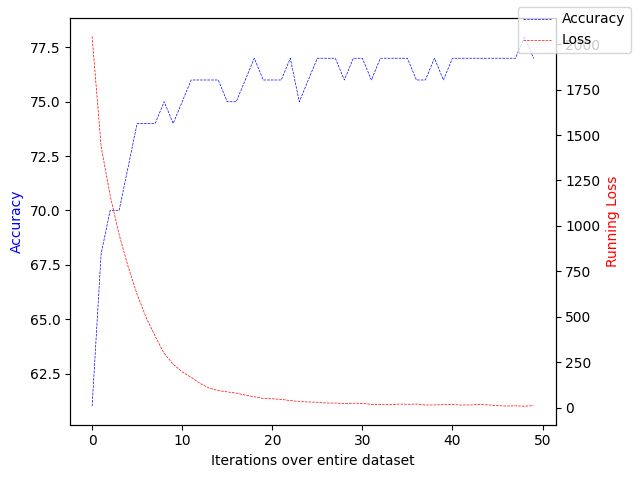

Testing on 10,000 test images ...
- Correct: 7739
- Total: 10000
- Accuracy: 77


77

In [12]:
# import matplotlib.pyplot as plt
# import numpy as np
# import time

# # create a new NN
# torch.manual_seed(1)
# net = Net()
# net.to(device)

# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.0)

# train_nn(net=net, epochs=50, optimizer=optimizer)
# test_nn(net=net, verbose=True)

Save the new NN model

In [13]:
# PATH = "./nn-models/cifar10-nn-model"
# torch.save(net.state_dict(), PATH)

Load the NN model

In [14]:
# PATH = "./nn-models/cifar10-nn-model"

# # load the pretrained NN model
# net = Net()
# net.load_state_dict(torch.load(PATH))
# net.to(device=device)

# test_nn(net=net, verbose=True)

Testing on 10,000 test images ...
- Correct: 7730
- Total: 10000
- Accuracy: 77


77

Freeze all the parameters except those from the last layer

In [15]:
def freeze_parameters(net: nn.Module):
    # freeze all the parameters in the NN
    for param in net.parameters():
        param.requires_grad = False

    # unfreeze all the parameters from the last layer and randomise the weights
    for param in net.out.parameters():
        param.requires_grad = True
        param.data = torch.rand(param.size(), device=device)

Gradient descent method

In [ ]:
# PATH = "./nn-models/cifar10-nn-model"

# # load the pretrained NN model
# net = Net()
# net.load_state_dict(torch.load(PATH))
# net.to(device=device)

# freeze_parameters(net=net)

# optimizer = torch.optim.Adagrad(net.parameters())
# loss_function = torch.nn.CrossEntropyLoss()

# train_nn(net=net, epochs=50, optimizer=optimizer, loss_function=loss_function)
# test_nn(net=net, verbose=True)

Population-based heuristic algorithm

Population of 50 individuals generated
Generation 0 -- Current best individual has a fitness value of 28.535776138305664
Generation 1 -- Current best individual has a fitness value of 26.350688934326172
Generation 2 -- Current best individual has a fitness value of 24.581024169921875
Generation 3 -- Current best individual has a fitness value of 24.499893188476562
Generation 4 -- Current best individual has a fitness value of 19.538970947265625
Generation 5 -- Current best individual has a fitness value of 19.538970947265625
Generation 6 -- Current best individual has a fitness value of 19.538970947265625
Generation 7 -- Current best individual has a fitness value of 19.538970947265625
Generation 8 -- Current best individual has a fitness value of 16.253454208374023
Generation 9 -- Current best individual has a fitness value of 16.253454208374023
Generation 10 -- Current best individual has a fitness value of 16.253454208374023
Generation 11 -- Current best individual has a fitness val

19

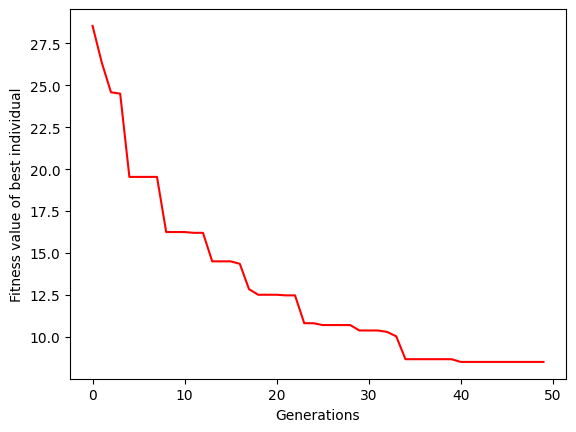

In [25]:
import random
from deap import creator, base, tools, algorithms

PATH = "./nn-models/cifar10-nn-model"

# load the pretrained NN model
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device=device)

all_data = []
for batch in trainloader:
    all_data.extend(batch)

freeze_parameters(net=net)

# genetic algorithm
n_bits = 8

dimensions = 0
for param in net.out.parameters():
    dimensions += param.numel()

population_size = 50
generations = 50
elitism = 5
crossover_probability = 0.9
uniform_crossover_probability = 0.5
mutation_probability = 0.1
mutation_flip_probability = 1.0 / (dimensions * n_bits)
min_bound = -1.0
max_bound = 1.0

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
# register the uniform crossover
toolbox.register("crossover", tools.cxUniform, indpb=uniform_crossover_probability)
# register the bit mutation
toolbox.register("mutation", tools.mutFlipBit, indpb=mutation_flip_probability)
# register the selection
toolbox.register("select", tools.selTournament, fit_attr='fitness')

def decode(individual):
    real_numbers = []
    for i in range(dimensions):
        chromosome = individual[i*n_bits:(i+1)*n_bits]
        bit_string = ''.join(map(str, chromosome))
        num_as_int = int(bit_string, 2) # convert to int from base 2 list
        num_in_range = min_bound + (max_bound - min_bound) * num_as_int / 2**n_bits
        real_numbers.append(num_in_range)

    return real_numbers

def calculate_fitness(individual):
    # put the parameters into the NN
    parameters = decode(individual=individual)
    parameters = torch.as_tensor(parameters, dtype=torch.float32, device=device)

    net.out.weight = torch.nn.Parameter(data=parameters[0:20480].reshape(10, 2048))
    net.out.bias = torch.nn.Parameter(data=parameters[20480:20490])

    # go over the dataset once
    running_loss = 0
    with torch.no_grad():
      images = all_data[0].to(device) # evaluate on the train or test data ??
      labels = all_data[1].to(device)

      preds = net(images) # predict entire dataset
      loss = F.cross_entropy(preds, labels) # calculate loss

    return loss.item(),

# generate an initial population
population = []
for _ in range(population_size):
    # generate random genes
    new_genes = []
    for _ in range(n_bits * dimensions):
        new_genes.append(random.randint(0, 1))

    # generate an individual from those random genes
    new_individual = creator.Individual(new_genes)
    # calculate their fitness
    new_individual.fitness.values = calculate_fitness(new_individual)

    population.append(new_individual)

print(f'Population of {len(population)} individuals generated')

best_individuals = []

# start generations loop
for g in range(generations):
    # select the next generation of individuals
    offspring = tools.selBest(population, elitism) + toolbox.select(population, len(population) - elitism, 2)
    offspring = list(map(toolbox.clone, offspring))

    # crossover
    for child1, child2 in zip(offspring[elitism::2], offspring[elitism+1::2]):
        # with a certain probability generate an offspring by uniform crossover
        if random.random() < crossover_probability:
            toolbox.crossover(child1, child2)
            # invalidate the fitness value of the offspring
            del child1.fitness.values
            del child2.fitness.values

    # mutation
    for mutant in offspring[elitism:]:
        # with a certain probability generate an offspring by bit mutation
        if random.random() < mutation_probability:
            toolbox.mutation(mutant)
            # invalidate the fitness value of the offspring
            del mutant.fitness.values

    # calculate the fitness of the offspring
    for individual in offspring:
        if not individual.fitness.valid:
            individual.fitness.values = calculate_fitness(individual)

    # replacement
    population[:] = offspring

    # track the best individuals
    # gather all the fitness values in one list and track the best fitness value
    all_fitness_values = [individual.fitness.values[0] for individual in population]
    best_individuals.append(min(all_fitness_values))
    print(f'Generation {g} -- Current best individual has a fitness value of {min(all_fitness_values)}')

# plot the best individuals from each generation
plt.plot(np.array(best_individuals), 'r')
plt.xlabel('Generations')
plt.ylabel('Fitness value of best individual')
# choose the best individual from the final population as the parameters (weights and biases) of the NN
best_individual = tools.selBest(population, 1)[0]
print(f'End of evolution -- Best individual has a fitness value of {best_individual.fitness.values}')

# put parameters back into the NN
parameters = decode(individual=best_individual)
parameters = torch.as_tensor(parameters, dtype=torch.float32, device=device)
net.out.weight = torch.nn.Parameter(data=parameters[0:20480].reshape(10, 2048))
net.out.bias = torch.nn.Parameter(data=parameters[20480:20490])

# test the NN
test_nn(net=net, verbose=True)